In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "SH_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path

In [2]:
%load_ext autoreload

# Load Files

In [ ]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_SH_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [ ]:
len(windmill)

In [ ]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [ ]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [ ]:
df = features.parallelize_extract(df)

In [ ]:
df,ply_models_rn,ws_rn = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,ws_wsr = features.extract_quantiles(df, "hws_uv_wsr")

In [ ]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [ ]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [ ]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["GSRN", "TIME_CET"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET"]).reset_index(drop=True)

In [ ]:
df_train.to_parquet(constant.SH_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.SH_SC_EVL_path, index=False)

# Neural Network Train

In [3]:
df_train = pd.read_parquet(constant.SH_SC_TRAIN_path)

In [4]:
len(df_train)

104844

In [5]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=50
hidden_size = 1000
output_size = 1

## Original Features


In [6]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [ ]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

In [ ]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"original_k_fold.png")

### Train model

In [7]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [8]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"original_model.pth")

Epoch 0 train loss: 0.10974057018756866
Epoch 10 train loss: 0.053012460470199585
Epoch 20 train loss: 0.049932487308979034
Epoch 30 train loss: 0.04942171648144722
Epoch 40 train loss: 0.048667799681425095


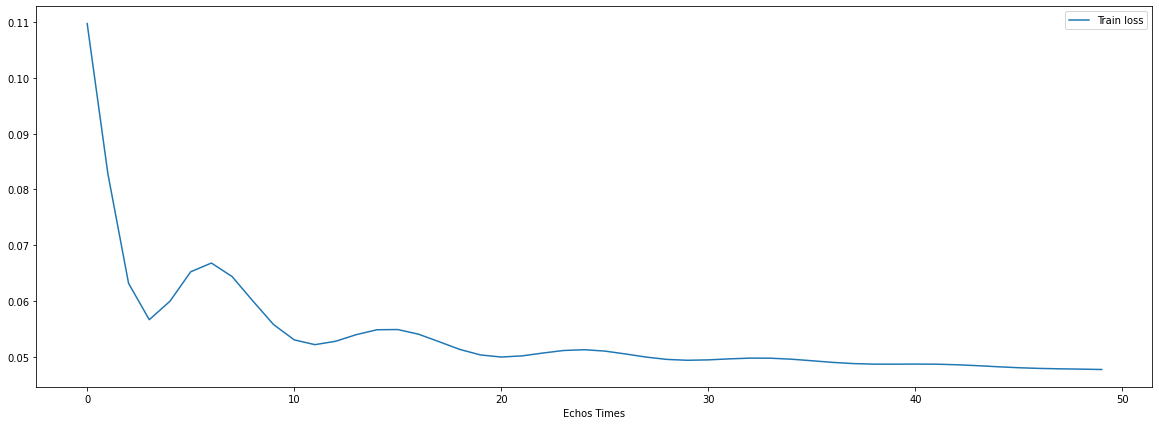

In [9]:
myplot.model_loss({"Train loss":train_hist_original}, path=plot_path+"original_loss.png")

## Windshear Features

In [10]:
model_wsr = MLP_Regression(
  input_size=44,
  hidden_size=hidden_size
)

In [ ]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

In [ ]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"wsr_k_fold.png")

### Train model

In [11]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [12]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"wsr_model.pth")

Epoch 0 train loss: 0.11148525774478912
Epoch 10 train loss: 0.047074317932128906
Epoch 20 train loss: 0.03512859344482422
Epoch 30 train loss: 0.029870469123125076
Epoch 40 train loss: 0.027276476845145226


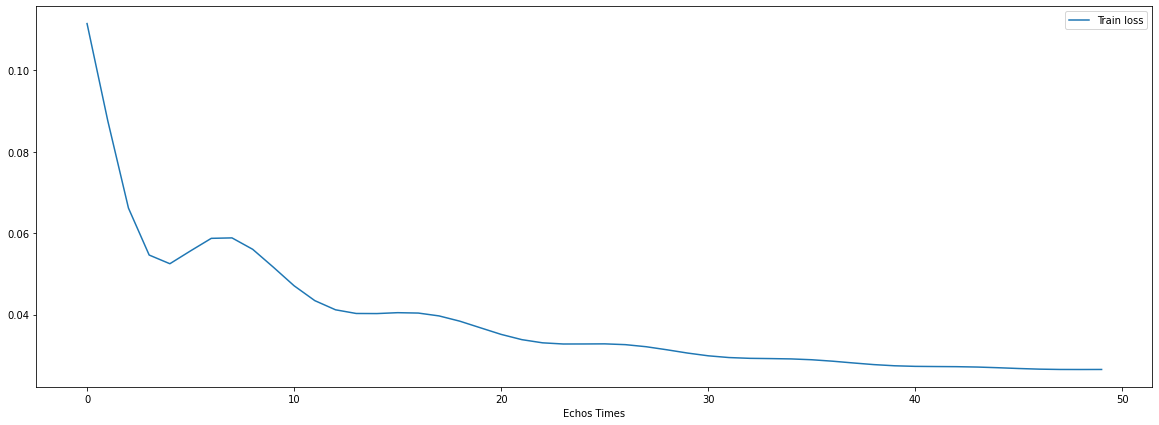

In [13]:
myplot.model_loss({"Train loss":train_hist_wsr}, path=plot_path+"wsr_loss.png")

## Geo Features

In [14]:
model_geo = MLP_Regression(
  input_size=46,
  hidden_size=hidden_size
)

In [ ]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

In [ ]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"geo_k_fold.png")

### Train model

In [15]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [16]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"geo_model.pth")

Epoch 0 train loss: 0.11433897167444229
Epoch 10 train loss: 0.050521060824394226
Epoch 20 train loss: 0.03654859960079193
Epoch 30 train loss: 0.030127577483654022
Epoch 40 train loss: 0.02661183290183544


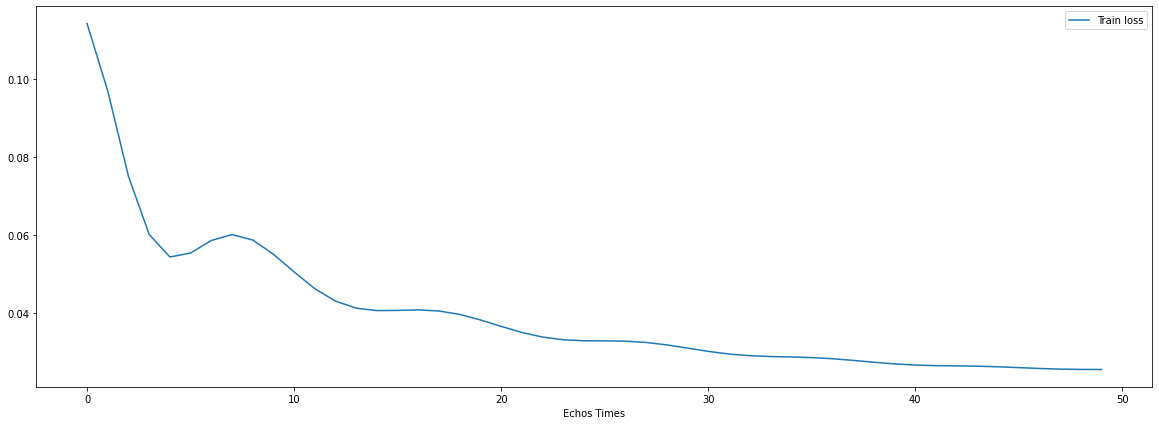

In [17]:
myplot.model_loss({"Train loss":train_hist_geo}, path=plot_path+"geo_loss.png")

## Semigeo Features

In [18]:
model_semigeo = MLP_Regression(
  input_size=47,
  hidden_size=1000
)

In [ ]:
# k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

In [ ]:
# myplot.k_fold_validation(n_groups, k_scores, path=plot_path+"semigeo_k_fold.png")

### Train model

In [19]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [20]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            path=model_path+"semigeo_model.pth")

Epoch 0 train loss: 0.10813194513320923
Epoch 10 train loss: 0.04454430192708969
Epoch 20 train loss: 0.03518323972821236
Epoch 30 train loss: 0.030051339417696
Epoch 40 train loss: 0.027100220322608948


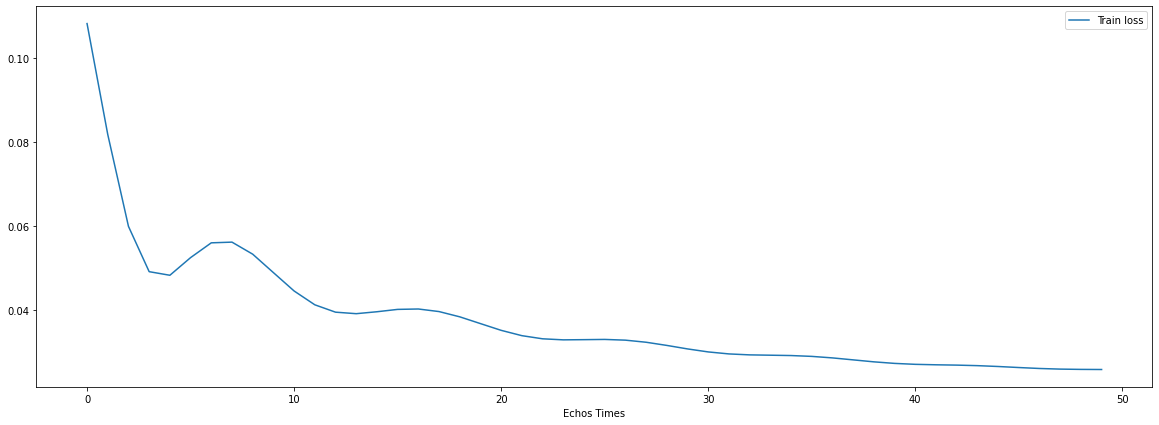

In [21]:
myplot.model_loss({"Train loss":train_hist_semigeo}, path=plot_path+"semigeo_loss.png")